# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


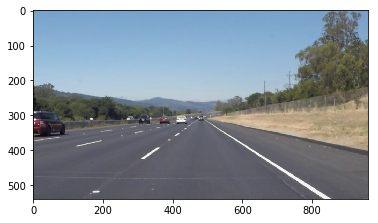

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [45]:

def line_intersection(line1, line2):
    """Finds the intersection point of two lines"""
    
    # Get diffs
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    # Get determinant
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    # Return False, False if no intersection
    div = det(xdiff, ydiff)
    if div == 0:
        return False, False

    # Return intersection point
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
       
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# Left line
left_line_x1 = 0
left_line_y1 = 0
left_line_x2 = 0
left_line_y2 = 0

# Right line
right_line_x1 = 0
right_line_y1 = 0
right_line_x2 = 0
right_line_y2 = 0

# Define min and max slopes that we'll filter lines on
LEFT_LANE_SLOPE_MIN = 0.5
LEFT_LANE_SLOPE_MAX = -10.0
RIGHT_LANE_SLOPE_MIN = -0.5
RIGHT_LANE_SLOPE_MAX = 10.0

def draw_lines(img, lines, color=[255, 0, 0], thickness=5, rawLines=True):
    """
    Draws lines on an image.
    """
    
    right_lines = []
    left_lines = []

    # If no input, draw big white lines on image from averaged time smoothed globals
    if lines is None:
        cv2.line(img, (int(left_line_x1), int(left_line_y1)), (int(left_line_x2), int(left_line_y2)), [255,255,255], 12) #draw left line
        cv2.line(img, (int(right_line_x1), int(right_line_y1)), (int(right_line_x2), int(right_line_y2)), [255,255,255], 12) #draw left line
        return
    
    # Go through lines, bucket into left lines and right lines based on slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y1-y2)/(x1-x2)) # Calculate slope
            if m <= LEFT_LANE_SLOPE_MIN and m >= LEFT_LANE_SLOPE_MAX:
                left_lines.append((m, x1,y1))
                if rawLines:
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif m >= RIGHT_LANE_SLOPE_MIN and m <= RIGHT_LANE_SLOPE_MAX:
                right_lines.append((m, x2,y2))
                if rawLines:
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Calculate median slope of left lines and draw it
    left_slope_avg = 0
    lx = 0
    ly = 0
    if( int(len(left_lines)) > 1 ):
        left_slope_avg, lx, ly = sorted(left_lines)[int(len(left_lines)/2)]
    left_length = 100
    l2x = lx+left_length
    l2y = ly+left_length*left_slope_avg
    line2 = ((int(lx), int(ly)), (int(l2x), int(l2y)))
#    cv2.line(img, (int(lx), int(ly)), (int(l2x),int(l2y)), [250,250,0], 5)

    # Calculate median slope of right lines and draw it
    right_slope_avg = 0
    rx = 0
    ry = 0
    if( int(len(right_lines)) > 1 ):
        right_slope_avg, rx, ry = sorted(right_lines)[int(len(right_lines)/2)]
    right_length = 100
    r2x = rx-right_length
    r2y = ry-right_length*right_slope_avg
    line1 = ((int(rx), int(ry)), (int(r2x), int(r2y)))
#    cv2.line(img, (int(rx), int(ry)), (int(r2x),int(r2y)), [250,250,70], 5)

    # Get image resolution
    height = img.shape[0]
    width = img.shape[1]

    # Create cutting mid and bottom lines for intersections 
    top_x1 = 0
    top_y1 = height * 0.60
    top_x2 = width
    top_y2 = height * 0.60
    bottom_x1 = 0
    bottom_y1 = height
    bottom_x2 = width
    bottom_y2 = height
    top_line = ((int(top_x1), int(top_y1)), (int(top_x2),int(top_y2)))
    bottom_line = ((int(bottom_x1), int(bottom_y1)), (int(bottom_x2),int(bottom_y2)))
#    cv2.line(img, (int(top_x1), int(top_y1)), (int(top_x2),int(top_y2)), [40,255,70], 5)
#    cv2.line(img, (int(bottom_x1), int(bottom_y1)), (int(bottom_x2),int(bottom_y2)), [40,255,70], 5)

    # Calculate intersections
    left = ((int(lx), int(ly)), (int(l2x), int(l2y)))
    right = ((int(rx), int(ry)), (int(r2x), int(r2y)))             
    sr_inter_x, sr_inter_y = line_intersection( bottom_line, right )
    sl_inter_x, sl_inter_y = line_intersection( bottom_line, left )
    tr_inter_x, tr_inter_y = line_intersection( top_line, right )
    tl_inter_x, tl_inter_y = line_intersection( top_line, left )

    # Draw lines
#    cv2.line(img, (int(sr_inter_x), int(sr_inter_y)), (int(tr_inter_x), int(tr_inter_y)), [0,255,70], 5)
#    cv2.line(img, (int(sl_inter_x), int(sl_inter_y)), (int(tl_inter_x), int(tl_inter_y)), [0,255,70], 5)
    
    # Return lines
    left_line = (int(sl_inter_x), int(sl_inter_y), int(tl_inter_x), int(tl_inter_y))
    right_line = (int(sr_inter_x), int(sr_inter_y), int(tr_inter_x), int(tr_inter_y))
    return left_line, right_line
 
    
# Define Region Of Interest trapezoid co-ords to look at in the image, as portion of image resolution
ROI_TOP_LEFT_X = 0.45
ROI_TOP_RIGHT_X = 0.55
ROI_TOP_Y = 0.60

# Define how much each frame of the image adds to the time smoothed average of land line positions
FRAME_SMOOTH_RATE = 0.1
show_smoothed_lines = False

def process_image(image):

    # Find edges, blur a bit first to smoothen gradients
    blurred = gaussian_blur(image, 7)
    edges = canny(blurred, 50, 150)
       
    # Mask image with wide trapezoid
    height = image.shape[0]
    width = image.shape[1]
    trapezoid = [np.array([(width*ROI_TOP_RIGHT_X, height*ROI_TOP_Y), # Top right, going anticlockwise...
                           (width*ROI_TOP_LEFT_X, height*ROI_TOP_Y),  # Top left
                           (width*0.0, height*1.0),  # Bottom left
                           (width*1.0, height*1.0)], # Bottom right
                           dtype=np.int32)]
    mask = region_of_interest(edges, trapezoid)

    # Find those lines
    lines = hough_lines(mask, 1, np.pi/180, 20, min_line_len=10, max_line_gap=90)
    
    # Draw those lines
    lines_drawn = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    # Draw the two main white output lines
    if show_smoothed_lines:
        draw_lines(lines_drawn, None)

    # Draw all the found lines if any
    if( lines is not None ):
        left_line, right_line = draw_lines(lines_drawn, lines)
    else:
        return image

    # Smoothed lines
    global right_line_x1, right_line_y1
    global left_line_x1, left_line_y1
    global right_line_x2, right_line_y2
    global left_line_x2, left_line_y2
    
    # Lines    
    x1, y1, x2, y2 = left_line
    xr1, yr1, xr2, yr2 = right_line
    
    # Left line
    left_to_x = x1
    left_to_y = y1
    left_to_x2 = x2
    left_to_y2 = y2

    # Right line
    right_to_x = xr1
    right_to_y = yr1
    right_to_x2 = xr2
    right_to_y2 = yr2

    # Reset
    if( left_line_x1 == 0 ):
        left_line_x1 = left_to_x
    if( left_line_y1 == 0 ):
        left_line_y1 = left_to_y
    if( left_line_x2 == 0 ):
        left_line_x2 = left_to_x2
    if( left_line_y2 == 0 ):
        left_line_y2 = left_to_y2
    if( right_line_x1 == 0 ):
        right_line_x1 = right_to_x
    if( right_line_y1 == 0 ): 
        right_line_y1 = right_to_y
    if( right_line_x2 == 0 ): 
        right_line_x2 = right_to_x2
    if( right_line_y2 == 0 ):
        right_line_y2 = right_to_y2

    # Update
    if( left_to_x > 0 and left_to_y > 0 and left_to_x2 > 0 and left_to_y2 > 0 ):
        left_line_x1  += FRAME_SMOOTH_RATE * (-left_line_x1 + left_to_x)
        left_line_y1  += FRAME_SMOOTH_RATE * (-left_line_y1 + left_to_y)
        left_line_x2  += FRAME_SMOOTH_RATE * (-left_line_x2 + left_to_x2)
        left_line_y2  += FRAME_SMOOTH_RATE * (-left_line_y2 + left_to_y2)
    if( right_to_x > 0 and right_to_y > 0 and right_to_x2 > 0 and right_to_y2 > 0 ):
        right_line_x1 += FRAME_SMOOTH_RATE * (-right_line_x1 + right_to_x)
        right_line_y1 += FRAME_SMOOTH_RATE * (-right_line_y1 + right_to_y)
        right_line_x2 += FRAME_SMOOTH_RATE * (-right_line_x2 + right_to_x2)
        right_line_y2 += FRAME_SMOOTH_RATE * (-right_line_y2 + right_to_y2)
     
    # Mix
    line_img = np.copy((mask)*0)
    result = weighted_img(lines_drawn, image)

    return result


def reset_smoothed_lines():
    global right_line_x1, right_line_y1
    global left_line_x1, left_line_y1
    global right_line_x2, right_line_y2
    global left_line_x2, left_line_y2

    # Left line
    left_line_x1 = 0
    left_line_y1 = 0
    left_line_x2 = 0
    left_line_y2 = 0

    # Right line
    right_line_x1 = 0
    right_line_y1 = 0
    right_line_x2 = 0
    right_line_y2 = 0



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

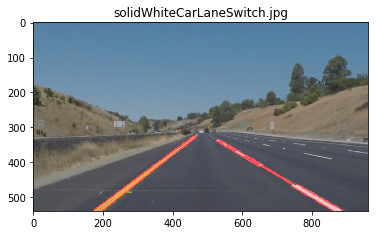

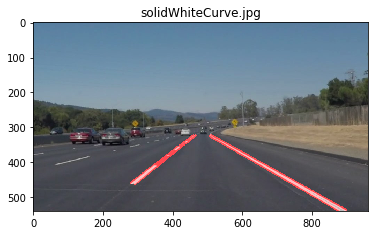

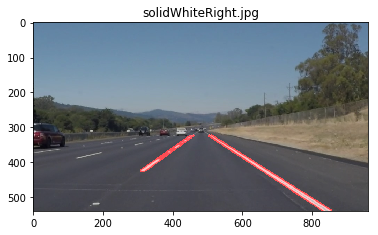

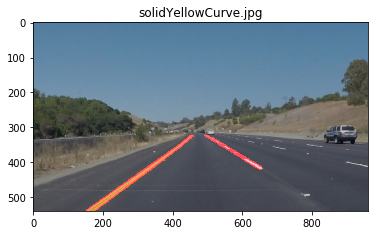

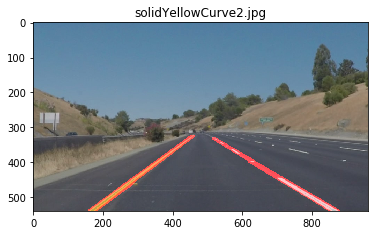

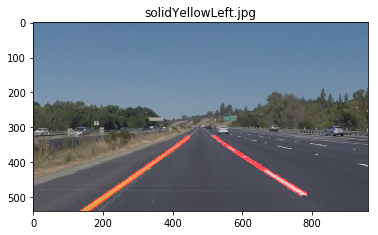

In [46]:
import os, fnmatch
images = fnmatch.filter(os.listdir("test_images/"), 'solid*.jpg')
show_smoothed_lines = False
for im in images:    
    image = mpimg.imread('test_images/' + im )
    image = process_image( image )
    plt.figure()
    plt.imshow(image)
    plt.title( im )
    mpimg.imsave( 'test_images/output_' + im, image )


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [48]:
show_smoothed_lines = True
reset_smoothed_lines()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 21.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.15 s, sys: 997 ms, total: 7.15 s
Wall time: 10.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [50]:
show_smoothed_lines = True
reset_smoothed_lines()
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:28<00:00, 21.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 19.5 s, sys: 3.23 s, total: 22.7 s
Wall time: 29.9 s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [53]:
show_smoothed_lines = True
reset_smoothed_lines()
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:20<00:00, 12.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 13.1 s, sys: 2.58 s, total: 15.6 s
Wall time: 23.4 s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [55]:
show_smoothed_lines = True
reset_smoothed_lines()
gor_output = 'greatoceanroad_out.mp4'
clip1 = VideoFileClip("greatoceanroad.mp4")
gor_clip = clip1.fl_image(process_image)
%time gor_clip.write_videofile(gor_output, audio=False)

[MoviePy] >>>> Building video greatoceanroad_out.mp4
[MoviePy] Writing video greatoceanroad_out.mp4


100%|██████████| 673/673 [01:07<00:00,  9.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: greatoceanroad_out.mp4 

CPU times: user 43.9 s, sys: 7.19 s, total: 51.1 s
Wall time: 1min 10s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(gor_output))